# Trabajo Practico 2 - Grupo 04 - Backbenchers


Integrantes:

* Catalina Basso
* Cristobal Alvarez
* Lucas Ruiz
* Dalmiro Vilaplana


## Imports

In [86]:
import re
import string
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Funciones

In [87]:
# Eliminar puntuación y convertir a minúsculas
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub("\d+", "", text)
    text = text.strip()
    return text

# Eliminar palabras vacías
stop_words = set(stopwords.words('spanish'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

stemmer = SnowballStemmer('spanish')

def stem_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

## Lecura CSV

Primero cargamos y vemos nuestro dataset

In [88]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tp2_train.csv')
train.head()

ID                                          review_es sentimiento
0   0  Uno de los otros críticos ha mencionado que de...    positivo
1   1  Una pequeña pequeña producción.La técnica de f...    positivo
2   2  Pensé que esta era una manera maravillosa de p...    positivo
3   3  Básicamente, hay una familia donde un niño peq...    negativo
4   4  El "amor en el tiempo" de Petter Mattei es una...    positivo

In [90]:
train.shape

(50000, 3)

In [91]:
test_kaggle = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tp2_test.csv')
test_kaggle.head()

ID                                          review_es
0  60000  La mayor virtud de esta película es su existen...
1  60001  No soy un experto cinéfilo, pero pocas veces m...
2  60002  Si no eres un incondicional del humor estilo T...
3  60003  No sé qué está pasando, si la gente se deja ll...
4  60004  Pero cuando amanece,y me quedo solo,siento en ...

In [92]:
test_kaggle.shape

(8599, 2)

# **Random Forest**

## Random Forest 1

### Algoritmo

#### Paso 1: Preprocesamiento de datos

In [93]:
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords)

Limpio aun mas mis datos para ver si mejoro el f1-score

In [94]:
train['review_clean'] = train['review_clean'].apply(stem_text)

#### Paso 2: Aplico Bag of Words

In [95]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(train['review_clean']).toarray()
y = train['sentimiento']

#### Paso 3: Dividir el conjunto en train y test

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Paso 4: Entrenar el modelo con Random Forest

In [97]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Paso 5: Evaluar que tan bien predice mi modelo

In [98]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8232
Classification Report:
              precision    recall  f1-score   support

    negativo       0.81      0.84      0.82      4961
    positivo       0.83      0.81      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000





1.  F1-Score = 0,82
2.  (aplicando "Stemming") F1- Score = 0,82 pero mejoro el recall y la presicion.



#### Paso 6: Guardar el modelo

In [99]:
joblib.dump(clf, 'random_forest_model_bow.pkl')
joblib.dump(vectorizer, 'bow_vectorizer.pkl')

['bow_vectorizer.pkl']



### Prediccion con el modelo de test dado

In [100]:
# Cargar el modelo y el vectorizador
clf_loaded = joblib.load('random_forest_model_bow.pkl')
vectorizer_loaded = joblib.load('bow_vectorizer.pkl')

# Aplicar la limpieza y eliminación de palabras vacías
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords)

# Transformar los textos de prueba en vectores usando el vectorizador cargado
X_test_new = vectorizer_loaded.transform(test_kaggle['review_clean']).toarray()

# Realizar predicciones
y_pred_new = clf_loaded.predict(X_test_new)

# Añadir las predicciones al DataFrame de prueba
test_kaggle['sentimiento'] = y_pred_new

columnas_mostrar = ['ID', 'sentimiento']
resultado_final_random = test_kaggle[columnas_mostrar]

print(resultado_final_random)

         ID sentimiento
0     60000    negativo
1     60001    negativo
2     60002    positivo
3     60003    positivo
4     60004    positivo
...     ...         ...
8594  68594    positivo
8595  68595    positivo
8596  68596    negativo
8597  68597    positivo
8598  68598    positivo

[8599 rows x 2 columns]


In [101]:
resultado_final_random.to_csv('random_forest_bag_of_words_fe_de_erratas.csv', index=False)

## Random Forest 2

### Algoritmo

Los primeros pasos son iguales al modelo anterior.

#### Paso 1: Preprocesamiento

In [102]:
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

#### Paso 2: Division en train y test

In [103]:
X = train['review_clean']
y = train['sentimiento']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Paso 3: Uso SMOTE

In [104]:
# Definir el pipeline con SMOTE y Random Forest
pipeline = ImbPipeline([
    ('vectorizer', CountVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

#### Paso 4: Busco nuevos hiperparametros

In [105]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

#### Paso 5: Evaluo mi modelo

In [106]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8235
Classification Report:
              precision    recall  f1-score   support

    negativo       0.82      0.83      0.82      4961
    positivo       0.83      0.82      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

Confusion Matrix:
[[4121  840]
 [ 925 4114]]


### Prediccion para el modelo de test dado

In [107]:
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

X_nuevos = test_kaggle['review_clean']

predicciones_nuevos = pipeline.predict(X_nuevos)

test_kaggle['sentimiento'] = predicciones_nuevos

columnas_mostrar = ['ID', 'sentimiento']
resultado_final_pipeline = test_kaggle[columnas_mostrar]

print(resultado_final_pipeline)

         ID sentimiento
0     60000    negativo
1     60001    positivo
2     60002    negativo
3     60003    negativo
4     60004    negativo
...     ...         ...
8594  68594    positivo
8595  68595    negativo
8596  68596    negativo
8597  68597    negativo
8598  68598    negativo

[8599 rows x 2 columns]


In [108]:
resultado_final_pipeline.to_csv('random_forest_pipeline.csv', index=False)

## Random Forest 3

Vamos a intentar encontrar los mejores hiperparametros para este tipo de clasificador, para eso vamos a apoyarnos en el random search que utilizamos en el TP1 y lo aplicaremos a este caso.

### Algoritmo

#### Paso 1: Preprocesamiento

In [109]:
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

#### Paso 2: Aplico Bag of Words

In [110]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(train['review_clean']).toarray()
y = train['sentimiento']

#### Paso 3: Dividir el conjunto en train y test

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Buscamos los mejores hiperparametros para nuestro RandomForest

In [112]:
#Cantidad de combinaciones que quiero probar
n=5

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,20)), #ponemos un rango de 20 porque tenemos muchas columnas que evaluar
               'ccp_alpha':np.linspace(0,0.05,n), #ccp para evitar overfitting
               'n_estimators': list(range(1,20))
               }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# creamos un random forest classifier
rf = RandomForestClassifier()

#Random Search Cross Validation
randomForest = RandomizedSearchCV(estimator=rf,
                              param_distributions = params_grid,
                              scoring='f1_macro',
                               cv=kfoldcv,
                              n_iter=n,
                              random_state = 20
                              )

randomForest.fit(X_train,y_train);

In [113]:
#creando el randomForest con los mejores parametros
random_forest_mejor = RandomForestClassifier().set_params(**randomForest.best_params_)
random_forest_mejor.fit(X_train,y_train)

RandomForestClassifier(max_depth=15, n_estimators=6)

In [114]:
# Vemos los mejores hiperparametros
print('Mejores Hiperparametros:',  randomForest.best_params_)

Mejores Hiperparametros: {'n_estimators': 6, 'max_depth': 15, 'criterion': 'gini', 'ccp_alpha': 0.0}


#### Paso 4: Realizamos nuestras predicciones y evaluamos sobre nuestro conjunto de entrenamiento y test

Para el caso de nuestro set de entrenamiento, evaluamos y vemos metricas

In [115]:
y_pred_train = random_forest_mejor.predict(X_train)

Text(50.722222222222214, 0.5, 'True')

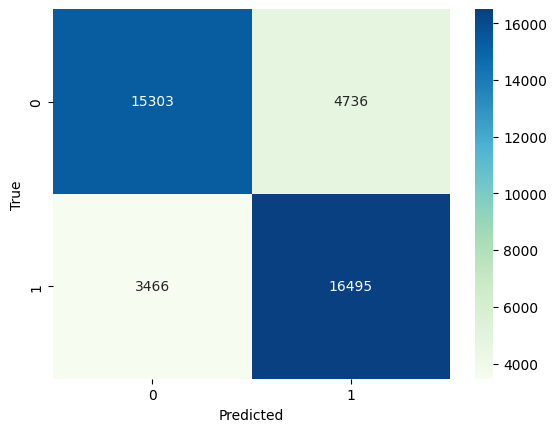

In [116]:
#Creo la matriz de confusión para nuestro conjunto de entrenamiento
tabla=confusion_matrix(y_train, y_pred_train)
#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [117]:
#vemos las metricas en el conjunto de entrenamiento
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

    negativo       0.82      0.76      0.79     20039
    positivo       0.78      0.83      0.80     19961

    accuracy                           0.79     40000
   macro avg       0.80      0.80      0.79     40000
weighted avg       0.80      0.79      0.79     40000



Repetimos para el set de evaluacion

In [118]:
y_pred = random_forest_mejor.predict(X_test)

Text(50.722222222222214, 0.5, 'True')

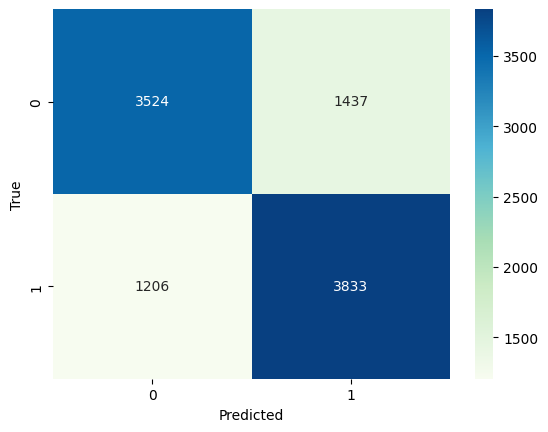

In [119]:
#Creo la matriz de confusión para nuestro conjunto de entrenamiento
tabla=confusion_matrix(y_test, y_pred)
#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [120]:
#vemos las metricas en el conjunto de entrenamiento
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negativo       0.75      0.71      0.73      4961
    positivo       0.73      0.76      0.74      5039

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



### Prediccion para el modelo de test dado

In [121]:
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

vectorizer = CountVectorizer(max_features=5000)
X_nuevos = vectorizer.fit_transform(test_kaggle['review_clean']).toarray()
y = train['sentimiento']

y_pred = random_forest_mejor.predict(X_nuevos)

test_kaggle['sentimiento'] = y_pred

columnas_mostrar = ['ID', 'sentimiento']
resultado_final_RF_hiperparametros = test_kaggle[columnas_mostrar]
print(resultado_final_RF_hiperparametros)

         ID sentimiento
0     60000    positivo
1     60001    negativo
2     60002    positivo
3     60003    negativo
4     60004    negativo
...     ...         ...
8594  68594    positivo
8595  68595    positivo
8596  68596    negativo
8597  68597    positivo
8598  68598    negativo

[8599 rows x 2 columns]


In [122]:
resultado_final_pipeline.to_csv('random_forest_mejores_hiperparametros.csv', index=False)

## Random Forest 4

Probemos que pasa si aumentamos la cantidad maxima de valores que puede tomar nuestro vector, es decir, aumentar la cantidad de palabras unicas que admitimos.

### Algoritmo

#### Paso 1: Preprocesamiento

In [123]:
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

#### Paso 2: Aplico Bag of Words

In [124]:
vectorizer = CountVectorizer(max_features=7500) #aumentamos a 7500
X = vectorizer.fit_transform(train['review_clean']).toarray()
y = train['sentimiento']

#### Paso 3: Dividir el conjunto en train y test

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
#Cantidad de combinaciones que quiero probar
n=5

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,20)), #ponemos un rango de 20 porque tenemos muchas columnas que evaluar
               'ccp_alpha':np.linspace(0,0.05,n), #ccp para evitar overfitting
               'n_estimators': list(range(1,20))
               }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

# creamos un random forest classifier
rf = RandomForestClassifier()

#Random Search Cross Validation
randomForest = RandomizedSearchCV(estimator=rf,
                              param_distributions = params_grid,
                              scoring='f1_macro',
                               cv=kfoldcv,
                              n_iter=n,
                              random_state = 20
                              )

randomForest.fit(X_train,y_train);

In [127]:
#creando el randomForest con los mejores parametros
random_forest_mejor = RandomForestClassifier().set_params(**randomForest.best_params_)
random_forest_mejor.fit(X_train,y_train)

RandomForestClassifier(max_depth=15, n_estimators=6)

In [128]:
# Vemos los mejores hiperparametros
print('Mejores Hiperparametros:',  randomForest.best_params_)

Mejores Hiperparametros: {'n_estimators': 6, 'max_depth': 15, 'criterion': 'gini', 'ccp_alpha': 0.0}


#### Paso 4: Realizamos nuestras predicciones sobre el conjunto de entrenamiento y evaluamos

In [129]:
y_pred_train = random_forest_mejor.predict(X_train)

Text(50.722222222222214, 0.5, 'True')

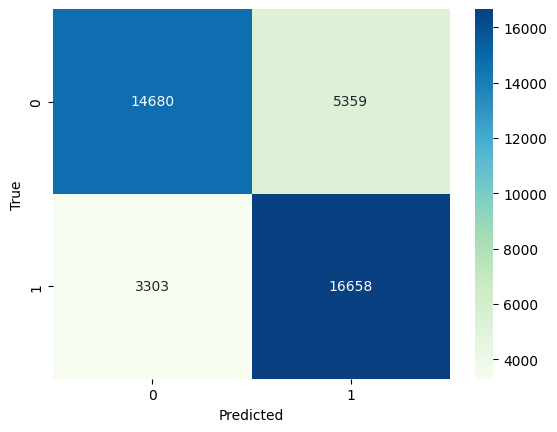

In [130]:
#Creo la matriz de confusión para nuestro conjunto de entrenamiento
tabla=confusion_matrix(y_train, y_pred_train)
#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [131]:
#vemos las metricas en el conjunto de entrenamiento
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

    negativo       0.82      0.73      0.77     20039
    positivo       0.76      0.83      0.79     19961

    accuracy                           0.78     40000
   macro avg       0.79      0.78      0.78     40000
weighted avg       0.79      0.78      0.78     40000



Repetimos para el set de evaluacion

In [132]:
y_pred = random_forest_mejor.predict(X_test)

Text(50.722222222222214, 0.5, 'True')

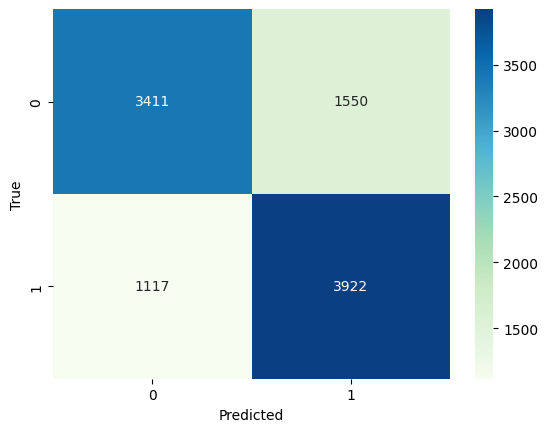

In [133]:
#Creo la matriz de confusión para nuestro conjunto de entrenamiento
tabla=confusion_matrix(y_test, y_pred)
#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [134]:
#vemos las metricas en el conjunto de entrenamiento
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negativo       0.75      0.69      0.72      4961
    positivo       0.72      0.78      0.75      5039

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



### Prediccion para el modelo de test dado

In [135]:
# Preprocesar los nuevos datos (limpiar, eliminar stopwords, aplicar stemming, etc.)
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

#vectorizamos para poder utilizar nuestro conjunto de palabras en nuestras predicciones.
vectorizer = CountVectorizer(max_features=7500)
X_nuevos = vectorizer.fit_transform(test_kaggle['review_clean']).toarray()
y = train['sentimiento']

# Hacer predicciones en los nuevos datos utilizando el modelo entrenado
y_pred = random_forest_mejor.predict(X_nuevos)

# Agregar las predicciones al DataFrame de los nuevos datos
test_kaggle['sentimiento'] = y_pred

columnas_mostrar = ['ID', 'sentimiento']
resultado_final_RF_hiperparametros_2 = test_kaggle[columnas_mostrar]

In [136]:
print(resultado_final_RF_hiperparametros_2)

         ID sentimiento
0     60000    positivo
1     60001    positivo
2     60002    negativo
3     60003    positivo
4     60004    positivo
...     ...         ...
8594  68594    positivo
8595  68595    positivo
8596  68596    positivo
8597  68597    positivo
8598  68598    positivo

[8599 rows x 2 columns]


In [137]:
resultado_final_RF_hiperparametros_2.to_csv('random_forest_mejores_hiperparametros_aumentar_vector.csv', index=False)

Conclusion: aumentar el total de palabras que admite nuestro vector mejora nuestro rendimiento. No podemos aumentarlo de manera exagerada tampoco debido a las limitaciones del google collab.

## Random Forest 5

### Algoritmo

#### Paso 1: Preprocesamiento

In [138]:
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

#### Paso 2: Vectorizar con BOW

In [139]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(train['review_clean']).toarray()
y = train['sentimiento']

#### Paso 3: Dividir el conjunto en train y test

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Paso 4: Modelo mi clasificador y lo evaluo en mi conjunto de prueba

In [141]:
rf = RandomForestClassifier(
    n_estimators=150,
    max_features='sqrt', # Usar raíz cuadrada de características
    max_depth=20,        # Limitar la profundidad del árbol
    min_samples_split=4, # Dividir nodo si hay al menos 4 muestras
    min_samples_leaf=2,  # Mínimo de muestras en una hoja
    bootstrap=True,      # Usar bootstraping
    random_state=42
)

In [142]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=150, random_state=42)

In [143]:
y_pred = rf.predict(X_test)

In [144]:
print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy en el conjunto de prueba: 0.816
Reporte de clasificación:
               precision    recall  f1-score   support

    negativo       0.83      0.79      0.81      4961
    positivo       0.80      0.85      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



### Prediccion para el modelo de test dado

In [145]:
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)
X_test_kaggle = vectorizer.transform(test_kaggle['review_clean']).toarray()

In [146]:
y_pred_kaggle = rf.predict(X_test_kaggle)

In [147]:
print(test_kaggle.columns)

Index(['ID', 'review_es', 'review_clean', 'sentimiento'], dtype='object')


In [148]:
submission = pd.DataFrame({'ID': test_kaggle['ID'], 'sentimiento': y_pred_kaggle})

In [149]:
submission.to_csv('submission_random_forest.csv', index=False)

## Random Forest 6

### Algoritmo

Pruebo formas de mejorar mi modelo. En este caso, vamos a juntar varias de las mejoras previamente mencionadas: incremento la cantidad maxima de valores que puede tomar nuestro vector, modifico hiperparametros del Random Forest (más detalles en el codigo), utilizo SMOTE y Snowball Stemmer

Los primeros pasos son iguales al modelo anterior.

#### Paso 1: Preprocesamiento

In [150]:
# Aplicar preprocesamiento y limpieza de texto
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords)

#### Paso 2: Division entre train y test

In [151]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = train['review_clean']
y = train['sentimiento']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Paso 3: Uso SMOTE

In [152]:
# Definir el pipeline con SMOTE y Random Forest con hiperparametros modificados
pipeline = ImbPipeline([
    ('vectorizer',  CountVectorizer(max_features=7500, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
    n_estimators=200,    # Aumentamos el número de árboles
    max_features='log2', # Usar log2 de características
    max_depth=25,        # Aumentamos la profundidad del árbol
    min_samples_split=3, # Reducimos el mínimo de muestras para dividir un nodo
    min_samples_leaf=1,  # Reducimos el mínimo de muestras en una hoja
    bootstrap=True,      # Usar bootstraping
    random_state=42
    ))
])

#### Paso 4: Entreno el modelo

In [153]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

#### Paso 5: Evaluo mi modelo

In [154]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.827
Classification Report:
              precision    recall  f1-score   support

    negativo       0.86      0.78      0.82      4961
    positivo       0.80      0.87      0.84      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
[[3874 1087]
 [ 643 4396]]


### Prediccion para el modelo de test dado

In [155]:
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords).apply(stem_text)

# Predicción para el conjunto de test de Kaggle
X_test_kaggle = test_kaggle['review_clean']
y_pred_kaggle = pipeline.predict(X_test_kaggle)

# Crear el DataFrame de resultados
random_forest_smote_modified = pd.DataFrame({'ID': test_kaggle['ID'], 'sentimiento': y_pred_kaggle})

print(random_forest_smote_modified)

         ID sentimiento
0     60000    positivo
1     60001    positivo
2     60002    positivo
3     60003    positivo
4     60004    positivo
...     ...         ...
8594  68594    positivo
8595  68595    positivo
8596  68596    positivo
8597  68597    positivo
8598  68598    positivo

[8599 rows x 2 columns]


In [156]:
random_forest_smote_modified.to_csv('random_forest_smote_modified.csv', index=False)

## Random Forest 7

Quiero probar que pasa si agarro mi mejor prediccion con este metodo pero lo entreno sin aplicar stemming, el cual descubri que no me da resultados muy buenos

Los primeros pasos son iguales al modelo anterior.

#### Paso 1: Preprocesamiento

In [157]:
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords)

#### Paso 2: Division entre train y test

In [158]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = train['review_clean']
y = train['sentimiento']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Paso 3: Uso SMOTE

In [159]:
# Definir el pipeline con SMOTE y Random Forest con hiperparametros modificados
pipeline = ImbPipeline([
    ('vectorizer',  CountVectorizer(max_features=7500, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
    n_estimators=200,    # Aumentamos el número de árboles
    max_features='log2', # Usar log2 de características
    max_depth=25,        # Aumentamos la profundidad del árbol
    min_samples_split=3, # Reducimos el mínimo de muestras para dividir un nodo
    min_samples_leaf=1,  # Reducimos el mínimo de muestras en una hoja
    bootstrap=True,      # Usar bootstraping
    random_state=42
    ))
])

#### Paso 4: Entreno el modelo

In [160]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

#### Paso 5: Evaluo mi modelo

In [161]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.827
Classification Report:
              precision    recall  f1-score   support

    negativo       0.86      0.78      0.82      4961
    positivo       0.80      0.87      0.84      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
[[3874 1087]
 [ 643 4396]]


### Prediccion para el modelo de test dado

In [162]:
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords)

# Predicción para el conjunto de test de Kaggle
X_test_kaggle = test_kaggle['review_clean']
y_pred_kaggle = pipeline.predict(X_test_kaggle)

# Crear el DataFrame de resultados
random_forest_smote_modified = pd.DataFrame({'ID': test_kaggle['ID'], 'sentimiento': y_pred_kaggle})

print(random_forest_smote_modified)

         ID sentimiento
0     60000    negativo
1     60001    positivo
2     60002    positivo
3     60003    negativo
4     60004    negativo
...     ...         ...
8594  68594    positivo
8595  68595    negativo
8596  68596    positivo
8597  68597    negativo
8598  68598    positivo

[8599 rows x 2 columns]


In [163]:
random_forest_smote_modified.to_csv('random_forest_smote_modified_2.0.csv', index=False)

## Random Forest 8

Ahora, por el mismo motivo que antes voy a probar que pasa si le saco la aplicacion de stemming a mi otra mejor prediccion de este modelo

#### Paso 1: Preprocesamiento

In [164]:
train['review_clean'] = train['review_es'].apply(clean_text).apply(remove_stopwords)

#### Paso 2: Division en train y test

In [165]:
X = train['review_clean']
y = train['sentimiento']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Paso 3: Uso SMOTE

In [166]:
# Definir el pipeline con SMOTE y Random Forest
pipeline = ImbPipeline([
    ('vectorizer', CountVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

#### Paso 4: Busco nuevos hiperparametros

In [167]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

#### Paso 5: Evaluo mi modelo

In [168]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8266
Classification Report:
              precision    recall  f1-score   support

    negativo       0.82      0.84      0.83      4961
    positivo       0.84      0.82      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
[[4149  812]
 [ 922 4117]]


### Prediccion para el modelo de test dado

In [169]:
test_kaggle['review_clean'] = test_kaggle['review_es'].apply(clean_text).apply(remove_stopwords)

X_nuevos = test_kaggle['review_clean']

predicciones_nuevos = pipeline.predict(X_nuevos)

test_kaggle['sentimiento'] = predicciones_nuevos

columnas_mostrar = ['ID', 'sentimiento']
resultado_final_pipeline = test_kaggle[columnas_mostrar]

print(resultado_final_pipeline)

         ID sentimiento
0     60000    negativo
1     60001    negativo
2     60002    negativo
3     60003    negativo
4     60004    negativo
...     ...         ...
8594  68594    positivo
8595  68595    negativo
8596  68596    positivo
8597  68597    negativo
8598  68598    negativo

[8599 rows x 2 columns]


In [170]:
resultado_final_pipeline.to_csv('random_forest_pipeline_2.0.csv', index=False)